Code for reproducing figure 4 comparison plots for individual differences and different network configurations

Comparison version showing all configurations side-by-side for easy visual comparison.

Eleanor Holton 28/03/2025

In [50]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy

# Get notebook's directory and find project root (transfer-interference directory)
try:
    # Try to get notebook path (works in Jupyter)
    notebook_path = Path(__file__).parent if '__file__' in globals() else Path.cwd()
except:
    notebook_path = Path.cwd()

# Navigate up to find project root (directory containing 'src' and 'data')
project_root = Path(notebook_path).resolve()
while not (project_root / 'src').exists() or not (project_root / 'data').exists():
    if project_root == project_root.parent:  
        # If we can't find it, assume we're in notebooks folder
        project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
        break
    project_root = project_root.parent

# Add project root to Python path
sys.path.insert(0, str(project_root))

# Setup figure output path
figure_path = project_root / 'figures/figure4_individual_differences_comparison'
os.makedirs(figure_path, exist_ok=True)

# Create matplotlib cache directory and clear font cache to pick up font changes
try:
    cache_dir = Path.home() / '.cache' / 'matplotlib'
    cache_dir.mkdir(parents=True, exist_ok=True)
    matplotlib.font_manager._load_fontmanager(try_read_cache=False)
except Exception as e:
    print(f"Note: Could not clear font cache: {e}")


from src.analysis import participant, ann, stats
from src.utils import figure_utils
from src.utils.figure_settings import schedule_colours, task_colours, cm_conv, med_fontsize, condition_order

import importlib
importlib.reload(ann)
importlib.reload(participant)
importlib.reload(figure_utils)
importlib.reload(stats)

<module 'src.analysis.stats' from '/home/kathrin/workspace/Structure-Function-Analysis-of-Network-Topologies/transfer-interference/src/analysis/stats.py'>

In [51]:
# Define configurations to compare
sim_configs = ['rich_50', 'gamma_e_1_50', 'gamma_e_2_50', 'gamma_1_50', 'lazy_50', 'standard_50']

# Import data
participant_trial_df = pd.read_csv(project_root / 'data/participants/trial_df.csv')
participant_group_df = pd.read_csv(project_root / 'data/participants/human_vonmises_fits.csv')

# Load all simulation data
ann_trial_data_dict = {}
ann_group_params_dict = {}
for config in sim_configs:
    config_path = project_root / f'data/simulations/{config}'
    if config_path.exists():
        ann_trial_data_dict[config] = ann.load_ann_data(config_path)
        vonmises_path = project_root / f'data/simulations/{config}_vonmises_fits.csv'
        if vonmises_path.exists():
            ann_group_params_dict[config] = pd.read_csv(vonmises_path)
    else:
        print(f"Warning: {config} data not found, skipping...")

## Histogram - Comparison across configurations

In [52]:
# Filter human data
participant_group_df = participant_group_df.loc[
    (participant_group_df['B_LL_B'] > participant_group_df['A_LL_B']), :
]
near_participants_group = participant_group_df[
    participant_group_df['condition'] == 'near'
].copy().reset_index(drop=True)

# Create comparison plot for histogram
fig, axes = plt.subplots(2, 3, figsize=[9*cm_conv, 6*cm_conv])

# Plot humans (first subplot)
ax = axes[0, 0]
figure_utils.plot_near_hist(near_participants_group, schedule_colours, ax=ax)
ax.set_title('Humans', fontsize=8)
ax.xaxis.label.set_fontsize(7)
ax.yaxis.label.set_fontsize(7)
ax.tick_params(labelsize=7)

# Plot each ANN configuration
for idx, config in enumerate([c for c in sim_configs if c in ann_group_params_dict], start=1):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Filter and prepare data for this configuration
    config_group = ann_group_params_dict[config].loc[
        ann_group_params_dict[config]['condition'] == 'near'
    ].copy()
    
    figure_utils.plot_near_hist(config_group, schedule_colours, ax=ax)
    ax.set_title(config, fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)

# Remove empty subplots if any
n_plotted = 1 + len([c for c in sim_configs if c in ann_group_params_dict])
for idx in range(n_plotted, 6):
    row = idx // 3
    col = idx % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
fig.savefig(
    os.path.join(figure_path, 'fig4A_near_hist_comparison.png'),
    dpi=500, bbox_inches="tight"
)
plt.close(fig)

## Individual behavioral metrics - Comparison across configurations

In [53]:
# Prepare data for all configurations
near_participants_trial = participant_trial_df[
    participant_trial_df['condition'] == 'near'
].copy().reset_index(drop=True)

near_participants_group = participant.add_behav_metrics(
    near_participants_group, near_participants_trial
)

# Prepare ANN data for all configurations
all_ann_behav_dfs = []
for config in sim_configs:
    if config in ann_trial_data_dict and config in ann_group_params_dict:
                # Use the single-configuration function
        config_group_params = ann_group_params_dict[config].loc[
            ann_group_params_dict[config]['condition'] == 'near'
        ]
        ann_behav_df = ann.add_ann_metrics_single(
            ann_trial_data_dict[config]['near'],
            config_group_params,
            group_name=config  # Use config name as group label (ANNs don't have splitters/lumpers)
        )
        # Add configuration identifier
        ann_behav_df['config'] = config
        all_ann_behav_dfs.append(ann_behav_df)

# Combine all data
grouped_df_all = pd.concat([near_participants_group] + all_ann_behav_dfs).reset_index(drop=True)
# Add ann column to identify source of data
grouped_df_all['ann'] = grouped_df_all['participant'].apply(
    lambda x: 1 if 'sim_' in str(x) else 0
)

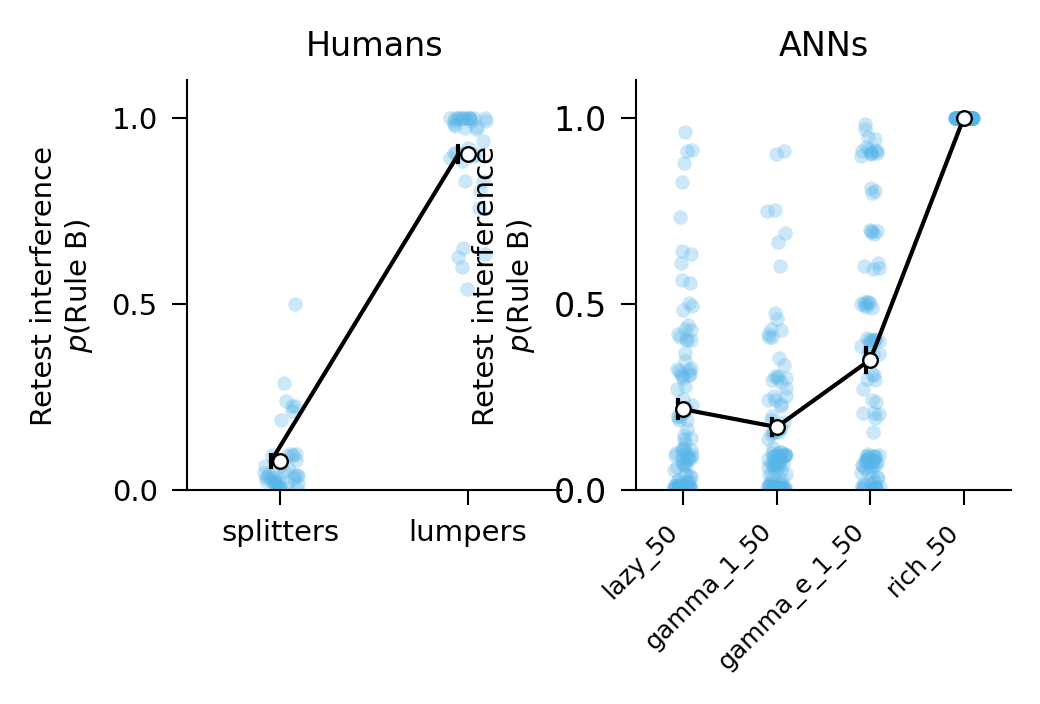

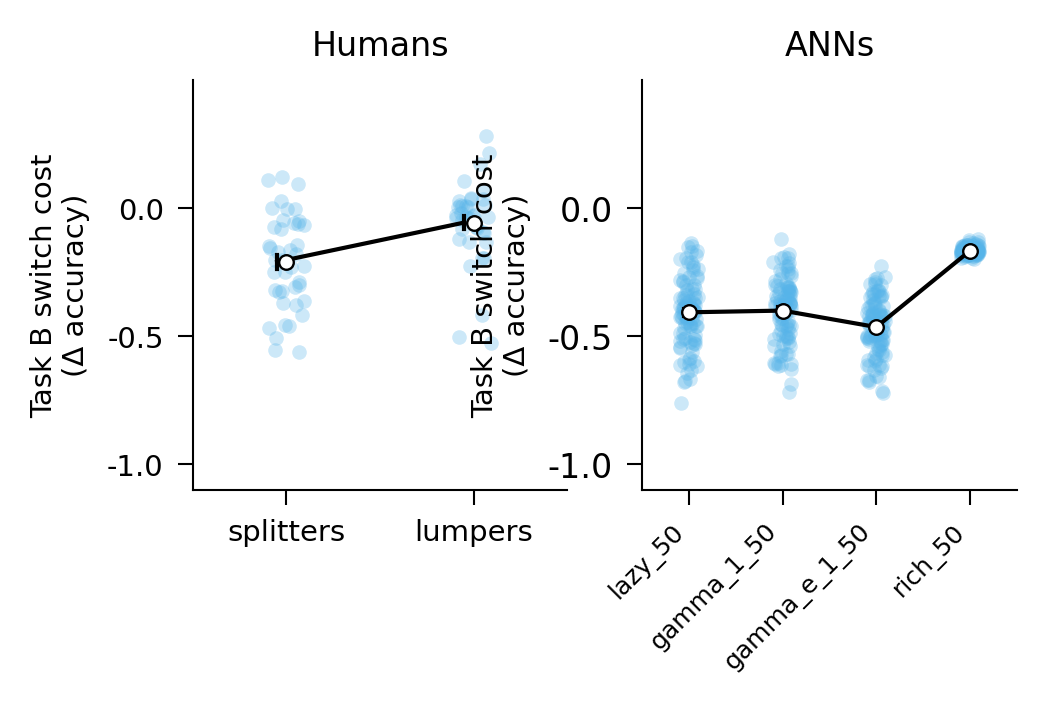

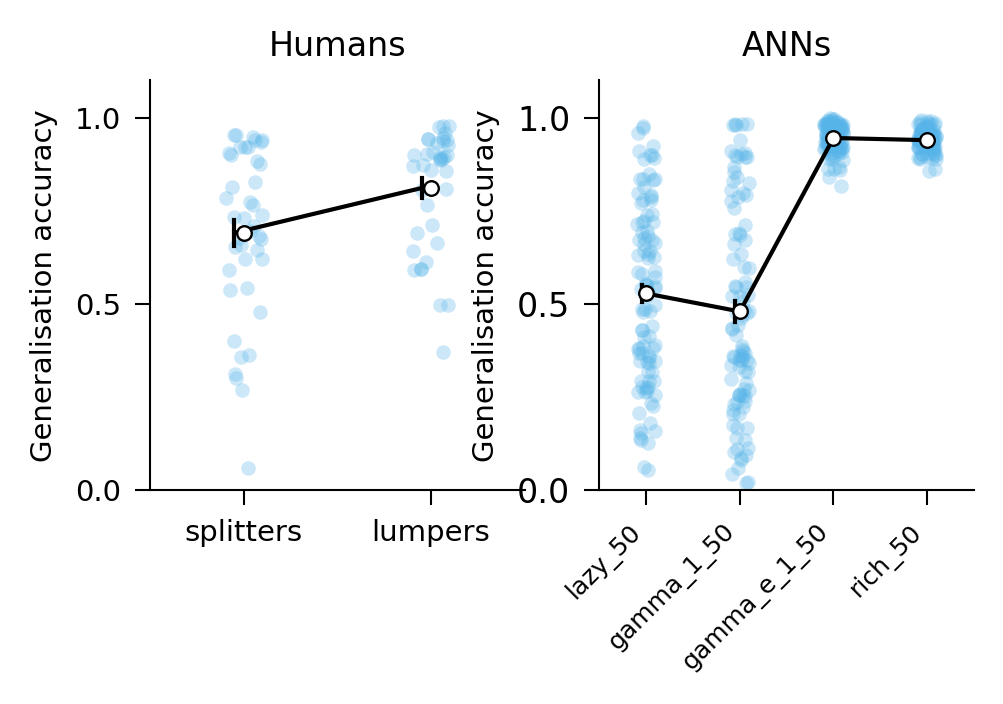

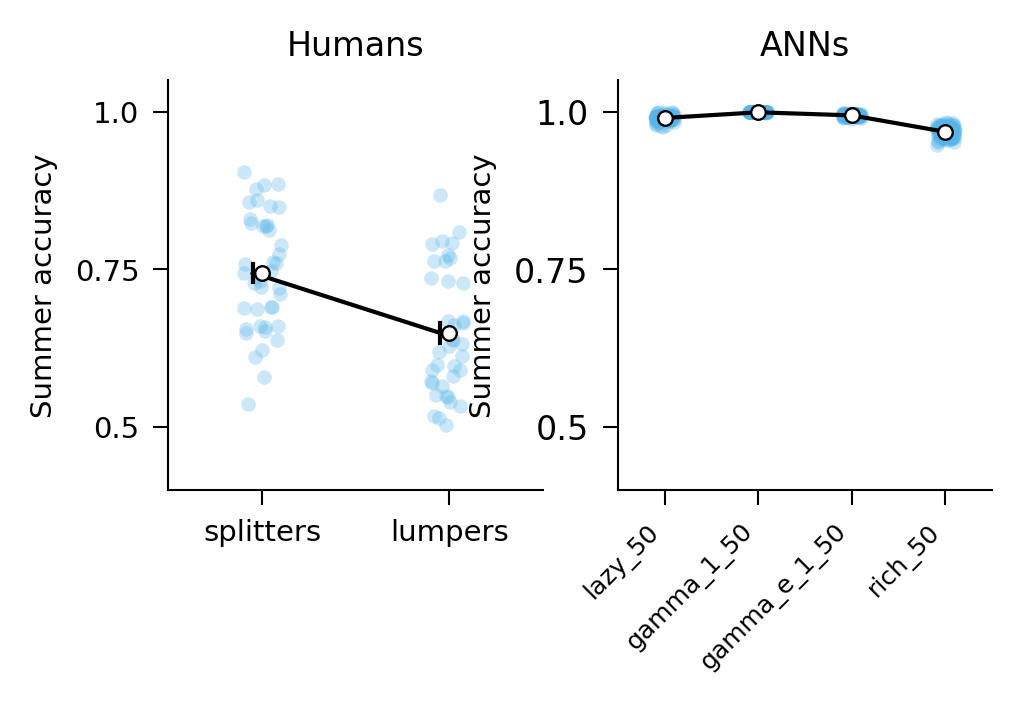

In [54]:
# Define variables to plot
variables = ['interference', 'transfer_error_diff', 'generalisation_acc', 'summer_accuracy', 'retest_error_diff']
ylabels = [
    'Retest interference\n$\it{p}$(Rule B)', 
    'Task B switch cost\n(Δ accuracy)', 
    'Generalisation accuracy', 
    'Summer accuracy',
    'Retest error diff'
]
letter = ['B', 'C', 'D', 'E', 'supp']

yticks = [
    np.arange(0, 1.1, 0.5), 
    np.arange(-1, 0.3, 0.5), 
    np.arange(0, 1.1, 0.5), 
    np.arange(0.5, 1.1, 0.25),
    np.arange(-1, 0.3, 0.5)
]
ytick_labs = [
    np.arange(0, 1.1, 0.5), 
    np.arange(-1, 0.3, 0.5), 
    np.arange(0, 1.1, 0.5), 
    np.arange(0.5, 1.1, 0.25),
    np.arange(-1, 0.3, 0.5)
]
ylims = [
    [0, 1.1], 
    [-1.1, 0.5], 
    [0, 1.1], 
    [0.4, 1.05],
    [-1.1, 0.5]
]

# Colors for individual differences
indiv_diff_colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181']

# Create comparison plots for each variable
for var, ytick, ytick_lab, ylim, ylab, letter_idx in zip(
    variables, yticks, ytick_labs, ylims, ylabels, letter
):
    # Create 1x2 grid: humans on left, all ANNs compared on right
    # Make it wider to accommodate all ANN config names
    fig, axes = plt.subplots(1, 2, figsize=[9*cm_conv, 4.5*cm_conv])
    
    # Plot humans (left subplot)
    ax = axes[0]
    human_data = grouped_df_all.loc[grouped_df_all['ann'] == 0]
    figure_utils.plot_id_1group(
        data=human_data, grouping='group', 
        group_order=['splitters', 'lumpers'], 
        group_names=['splitters', 'lumpers'], 
        var=var, yticks=ytick, ytick_labs=ytick_lab, 
        ylim=ylim, ylab=ylab, 
        colors=schedule_colours[1], 
        add_tests=0, p_value=np.nan, y_coord=np.nan, ax=ax
    )
    ax.set_title('Humans', fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)
    
    # Plot all ANN configurations together (right subplot)
    ax = axes[1]
    # Get all ANN data
    ann_data = grouped_df_all.loc[grouped_df_all['ann'] == 1].copy()
    
    # Filter out NaN values
    ann_data = ann_data.dropna(subset=['group', var])
    
    if len(ann_data) > 0:
                        # Define order from lazy to rich (to match humans: splitters to lumpers)
        # Order: lazy (low interference) -> rich (high interference)
        ann_config_order = ['lazy_50', 'gamma_1_50', 'gamma_e_2_50', 'gamma_e_1_50', 'standard_50', 'rich_50']
        
        # Get available configs and sort them according to the defined order
        available_configs = [c for c in ann_config_order if c in ann_data['group'].values]
        
        if len(available_configs) > 0:
            figure_utils.plot_id_1group(
                data=ann_data, grouping='group',
                group_order=available_configs,
                group_names=available_configs,
                var=var, yticks=ytick, ytick_labs=ytick_lab,
                ylim=ylim, ylab=ylab,
                colors=schedule_colours[1],
                add_tests=0, p_value=np.nan, y_coord=np.nan, ax=ax
            )
            ax.set_title('ANNs', fontsize=8)
            ax.xaxis.label.set_fontsize(7)
            ax.yaxis.label.set_fontsize(7)
            # Smaller font for x-axis tick labels (config names) to fit all names
            # Rotate x-axis labels to prevent overlap
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=6)

plt.tight_layout()
fig.savefig(
    os.path.join(figure_path, f'fig4{letter_idx}_{var}_comparison.png'),
    dpi=500, bbox_inches="tight"
)
plt.close(fig)